In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$f_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta_i^\top x$$

# Generate Communication Network

In [2]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes (Change this to reflect supply chain structure)
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

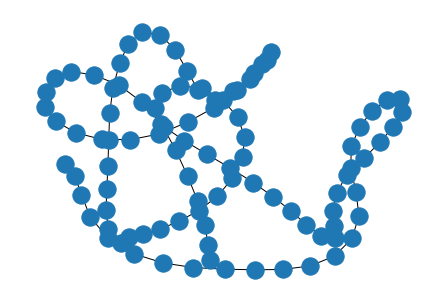

In [3]:
nx.draw(G)

# Problem Parameters

In [4]:
theta_0 = (1/(n+3))*np.ones((n,n))-np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
print(theta)
xi = n

[[-1.0914496  -0.14128028 -0.06722529 ... -0.03150991 -0.12060165
  -0.10775121]
 [-0.02908543 -1.08124011  0.02833266 ... -0.13391117  0.08551153
  -0.14326022]
 [ 0.03108173 -0.24482784 -0.91481363 ...  0.05561662  0.0742585
   0.05806982]
 ...
 [ 0.01536031  0.07282041  0.0337155  ... -0.99797979 -0.02340239
   0.06620679]
 [ 0.24099873 -0.01116129  0.15092367 ... -0.12427286 -1.02256617
   0.12132838]
 [-0.0999007  -0.0475933  -0.15087438 ... -0.01778613  0.09624598
  -1.03039645]]


# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return 2*np.dot(theta,x) + xi

# Centralized GD

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 3590.35it/s]


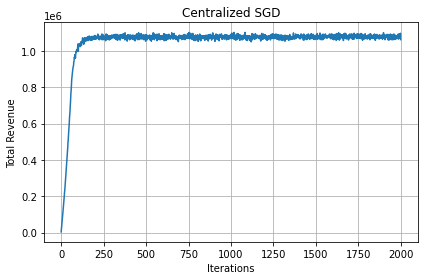

[  0.         100.         100.          34.01874372 100.
  41.79332444 100.         100.         100.         100.
 100.         100.           0.          16.64757916 100.
 100.         100.         100.         100.         100.
 100.         100.          69.07183331   0.          28.70658746
 100.         100.          98.23856633 100.         100.
 100.         100.         100.         100.         100.
 100.         100.          96.4191986  100.         100.
 100.         100.          20.63991527 100.         100.
 100.          84.87286716 100.         100.          36.39945107
 100.         100.         100.         100.          64.22640613
 100.         100.          73.83657271  98.23816416 100.
 100.         100.         100.         100.         100.
 100.         100.          16.81867564 100.         100.
  81.93103123 100.         100.          87.4415958  100.
  84.47909041 100.          58.49143073  83.46594929 100.
  65.24470947 100.           0.          75.2966

In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
p_max = n  # Set maximum price
rev = []
x_hist = []
iterations = 2000

# Run centralized GD
for i in trange(iterations):
    xi = n+np.random.randn(1)
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    x = np.clip(x,0,p_max)
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.title('Centralized SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/central_sgd.png')
plt.show()

print(x)

In [7]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

# Distributed SGD with synchronous information

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.74it/s]


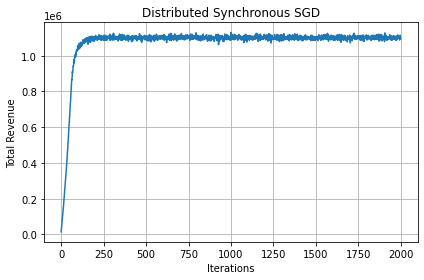

[  0.         100.         100.          33.96385388 100.
  41.73837494 100.         100.         100.         100.
 100.         100.           0.          16.55433194 100.
 100.         100.         100.         100.         100.
 100.         100.          69.02057159   0.          28.67705058
 100.         100.          98.20461589 100.         100.
 100.         100.         100.         100.         100.
 100.         100.          96.34510308 100.         100.
 100.         100.          20.52950962 100.         100.
 100.          84.75828327 100.         100.          36.34477736
 100.         100.         100.         100.          64.18232221
 100.         100.          73.78770737  98.19595687 100.
 100.         100.         100.         100.         100.
 100.         100.          16.7616444  100.         100.
  81.85889146 100.         100.          87.42049009 100.
  84.36166911 100.          58.42238591  83.46363477 100.
  65.24171502 100.           0.          75.2641

In [8]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_cent = []
x_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    x_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        X[j] += step*grad_revenue(X[j],theta,xi)
        temp.append(total_revenue(X[j],theta,xi))
    rev_cent.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_cent)
plt.grid()
plt.title('Distributed Synchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_sync.png')
plt.show()

print(np.mean(X,axis=0))

In [9]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

In [10]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.0973295420577094


# Distributed SGD with asynchronous information

100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.49it/s]


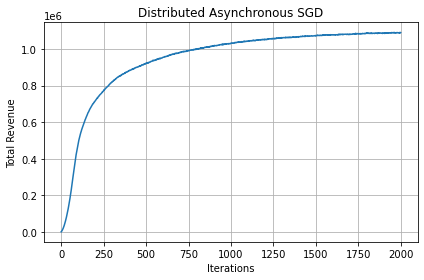

[  0.         100.         100.          33.32348034 100.
  41.08640307 100.         100.         100.         100.
 100.         100.           0.          15.59059301 100.
 100.          99.74814299 100.         100.         100.
 100.         100.          68.55436726   0.          28.39804234
 100.         100.          97.84732496 100.         100.
 100.         100.         100.         100.         100.
 100.         100.          95.50540538 100.         100.
 100.         100.          19.29915001 100.         100.
 100.          83.48817577 100.         100.          35.81253039
 100.         100.         100.         100.          63.71463095
 100.         100.          73.24179052  97.71442721 100.
 100.         100.         100.         100.         100.
 100.         100.          16.14900475 100.         100.
  81.03031683 100.         100.          87.19861865 100.
  83.07347251 100.          57.65129039  83.4045453  100.
  65.15335176 100.           0.          74.8524

In [11]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if not G.nodes[node]['informed']:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
        else:
            G.nodes[node]['xi'] = xi
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_async.png')
plt.show()

print(np.mean(X,axis=0))

In [12]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 14.134189617932046


# Fully connected graph

100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.80it/s]


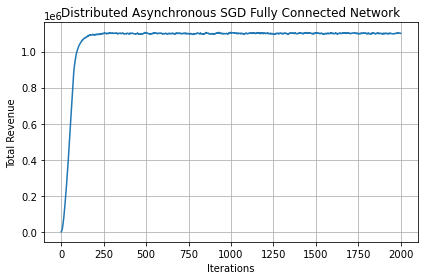

[  0.         100.         100.          34.00002899 100.
  41.77665831 100.         100.         100.         100.
 100.         100.           0.          16.6015899  100.
 100.         100.         100.         100.         100.
 100.         100.          69.05505118   0.          28.70798978
 100.         100.          98.23721248 100.         100.
 100.         100.         100.         100.         100.
 100.         100.          96.39100027 100.         100.
 100.         100.          20.58143919 100.         100.
 100.          84.813737   100.         100.          36.38323045
 100.         100.         100.         100.          64.21804856
 100.         100.          73.82728861  98.22991195 100.
 100.         100.         100.         100.         100.
 100.         100.          16.79944767 100.         100.
  81.90199027 100.         100.          87.45250399 100.
  84.41856144 100.          58.46385508  83.48794573 100.
  65.26841747 100.           0.          75.2992

In [13]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.erdos_renyi_graph(n,0.2)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Fully Connected Network')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_fc.png')
plt.show()

print(np.mean(X,axis=0))

In [14]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.018859828242458018


# Erdos Renyi random graph p=0.2

100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.54it/s]


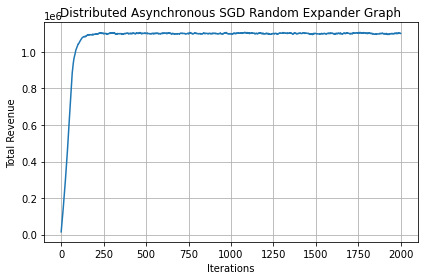

[  0.         100.         100.          33.99144382 100.
  41.76308263 100.         100.         100.         100.
 100.         100.           0.          16.58742145 100.
 100.         100.         100.         100.         100.
 100.         100.          69.05209849   0.          28.70582019
 100.         100.          98.23419766 100.         100.
 100.         100.         100.         100.         100.
 100.         100.          96.368015   100.         100.
 100.         100.          20.55217378 100.         100.
 100.          84.78778404 100.         100.          36.37120817
 100.         100.         100.         100.          64.21220339
 100.         100.          73.810458    98.22861185 100.
 100.         100.         100.         100.         100.
 100.         100.          16.79047372 100.         100.
  81.88381673 100.         100.          87.4483902  100.
  84.39119782 100.          58.45463118  83.48915975 100.
  65.26450648 100.           0.          75.2826

In [15]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Random Expander Graph')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_expander.png')
plt.show()

print(np.mean(X,axis=0))

In [16]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.041021729981994735
